<a href="https://colab.research.google.com/github/nfaggian/record_linkage/blob/master/simple_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Record linkage: Simple classifier

In [1]:
%%capture dependency_log
!pip install jellyfish tqdm matplotlib

In [2]:
import numpy as np
import pandas as pd
import tqdm

import uuid

import jellyfish as jf
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML, display, clear_output

## GCP authentication
- - - 

In [3]:
try: 
    from google.colab import auth
    auth.authenticate_user()
except:     
    try:
        import google.auth
        credentials, project = google.auth.default()
    except:
        raise Exception('Google cloud authentication required!')

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [4]:
%env GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian

project_id = 'anz-pso-nfaggian'

env: GOOGLE_CLOUD_PROJECT=anz-pso-nfaggian


## Retrieve donor and contributions data

In [5]:
query = f"""
SELECT
  * 
FROM
  dedup.donors
WHERE MOD(ABS(FARM_FINGERPRINT(CAST(donor_id AS STRING))), 1000) = 0
"""

raw_donors = pd.io.gbq.read_gbq(query, project_id=project_id, dialect='standard')
raw_donors = raw_donors.sort_values(by='donor_id')
print(raw_donors.shape)
raw_donors.head()

/home/nfaggian/development/miniconda/envs/py3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


(726, 10)


,donor_id,last_name,first_name,address_1,address_2,city,state,zip,employer,occupation
220,404,1-28-07 cash deposits,None,None,None,None,il,None,None,None
548,422,12 congressional district afl-cio cope cont. fund,None,59 magnolia dr.,None,belleville,il,62221,None,None
295,616,1420 west lexington partnership,None,1420 west lexington partnership,None,chicago,il,60607,None,None
309,988,18th ward democratic org,None,8150 s kedzie ave,None,chicago,il,60652,None,None
300,2158,35th & indiana currency exchange,None,126 e. 35th street,None,chicago,il,60616,None,None


**Data preperation**
- - - 

In [6]:
def transform(record):
  """
  Perform some simple transformations on to clean up donor data.
  """
  
  # combine the first and last name
  return {
      'donor_id': record.donor_id,
          'city': f"{record.city or ' '}".strip().lower(),
          'name': f"{record.first_name or ' '} {record.last_name or ' '}".strip().lower(),
       'address': f"{record.address_1 or ' '} {record.address_2 or ' '}".strip().lower(), 
         'state': f"{record.state or ' '}".strip().lower(),
           'zip': f"{record.zip or ' '}".strip().lower(),
    'occupation': f"{record.occupation or ' '}".strip().lower(),
      'employer': f"{record.employer or ' '}".strip().lower(),
     'is_person': record.first_name is not None }

In [7]:
donors = [] 
for row, record in tqdm.tqdm(raw_donors.iterrows(), total=raw_donors.shape[0]):
    donors.append(transform(record))
donors = pd.DataFrame(donors)
donors.head()

100%|██████████| 726/726 [00:00<00:00, 1642.29it/s]


,address,city,donor_id,employer,is_person,name,occupation,state,zip
0,,,404,,False,1-28-07 cash deposits,,il,
1,59 magnolia dr.,belleville,422,,False,12 congressional district afl-cio cope cont. fund,,il,62221
2,1420 west lexington partnership,chicago,616,,False,1420 west lexington partnership,,il,60607
3,8150 s kedzie ave,chicago,988,,False,18th ward democratic org,,il,60652
4,126 e. 35th street,chicago,2158,,False,35th & indiana currency exchange,,il,60616


## Comparing donors (names and addresses): forming a distance table
- - -

In [8]:
def comparator(record_a, record_b):
  """
  Compares one field to another, using a series of distance metrics.
  """
  return {
    'donor_id1': record_a.donor_id,
    'donor_id2': record_b.donor_id,
    # name
    'jaro_name': jf.jaro_winkler(record_a['name'], record_b['name']),
    'phonetic_name': jf.match_rating_comparison(record_a['name'], record_b['name']),
    'damerau_name': jf.damerau_levenshtein_distance(record_a['name'], record_b['name']),
    # address  
    'jaro_address': jf.jaro_winkler(record_a['address'], record_b['address']),
    'phonetic_address': jf.match_rating_comparison(record_a['address'], record_b['address']),  
    'damerau_address': jf.damerau_levenshtein_distance(record_a['address'], record_b['address']),  
   }


In [107]:
distance_table = []
for row_a, record_a in tqdm.tqdm(donors.iterrows(), total=donors.shape[0]):
      for row_b, record_b in donors.iterrows():
            if row_a == row_b: continue    
            distance_table.append(comparator(record_a, record_b)) 
distance_table = pd.DataFrame(distance_table)

100%|██████████| 726/726 [04:57<00:00,  2.66it/s]


In [10]:
distance_table = distance_table.sort_values(by='jaro_name', ascending=False)

## Building a duplicate detector
- - -

Using the metrics we just calculated - let us build a simple duplicate detector, based on the following rules:

* jaro distances which are closer to 1.0 are good examples of duplicates.
* damerau distances which are closer to zero are good example of duplicates. 

We can set this threshold by looking at the distribution of the distance metrics for our small dataset, under the assumption that our small sample contains some of the common errors we will see in the larger dataset.

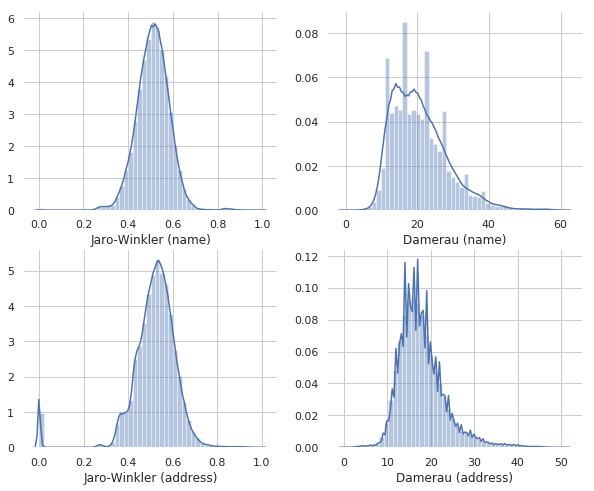

In [27]:
sns.set(style="whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.despine(fig, left=True, bottom=True)

sns.distplot(distance_table['jaro_name'], ax=ax1)
ax1.set_xlabel('Jaro-Winkler (name)')

sns.distplot(distance_table['damerau_name'], ax=ax2)
ax2.set_xlabel('Damerau (name)')

sns.distplot(distance_table['jaro_address'], ax=ax3)
ax3.set_xlabel('Jaro-Winkler (address)')

sns.distplot(distance_table['damerau_address'], ax=ax4);
ax4.set_xlabel('Damerau (address)');

Using the 99th and 1st percentiles we can setthresholds for similarity:

In [79]:
print(f"""
 jaro_name    :{distance_table['jaro_name'].quantile(0.99)}
 jaro_address :{distance_table['jaro_address'].quantile(0.99)}
 damerau_name    :{distance_table['damerau_name'].quantile(0.01)}
 damerau_address :{distance_table['damerau_address'].quantile(0.01)}
""") 


 jaro_name    :0.6725895863395869
 jaro_address :0.7111111111111111
 damerau_name    :9.0
 damerau_address :9.0



These thresholds correspond to the following partitionining of the subset of donor data; where **red** represents the range of observed similarity scores that represent non-duplicates and **green** represents duplicates.

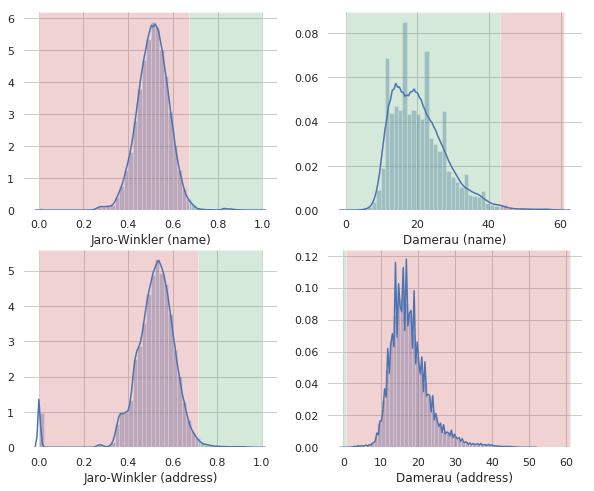

In [84]:
sns.set(style="whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
sns.despine(fig, left=True, bottom=True)

sns.distplot(distance_table['jaro_name'], ax=ax1)
ax1.set_xlabel('Jaro-Winkler (name)')
threshold = distance_table['jaro_name'].quantile(0.99)
ax1.axvspan(threshold, 1.0, facecolor='g', alpha=0.25)
ax1.axvspan(0, threshold, facecolor='r', alpha=0.25)

sns.distplot(distance_table['damerau_name'], ax=ax2)
ax2.set_xlabel('Damerau (name)')
threshold = distance_table['damerau_name'].quantile(0.99)
ax2.axvspan(0, threshold, facecolor='g', alpha=0.25)
ax2.axvspan(threshold, distance_table['damerau_name'].max(), facecolor='r', alpha=0.25)

sns.distplot(distance_table['jaro_address'], ax=ax3)
ax3.set_xlabel('Jaro-Winkler (address)')
threshold = distance_table['jaro_address'].quantile(0.99)
ax3.axvspan(threshold, 1.0, facecolor='g', alpha=0.25)
ax3.axvspan(0, threshold, facecolor='r', alpha=0.25)

sns.distplot(distance_table['damerau_address'], ax=ax4);
ax4.set_xlabel('Damerau (address)');
hreshold = distance_table['damerau_address'].quantile(0.99)
ax4.axvspan(0, threshold, facecolor='g', alpha=0.25)
ax4.axvspan(threshold, distance_table['damerau_name'].max(), facecolor='r', alpha=0.25);

Using the mean operator we can form a simple classifier that assumes equal importance of each distance metric:

In [86]:
def baseline_classifier(record):
    """
    Simple voting classifier.
    * assumes an equal weighting for the different types of distance metrics. 
    """
    votes = [
        record['jaro_name'] > 0.67258,
        record['jaro_address'] > 0.7111,
        record['damerau_name'] < 9,
        record['damerau_address'] < 9]
    return np.mean(votes)    

## Using the duplicate detector

In [109]:
classification_column = []
for row, record in tqdm.tqdm(distance_table.iterrows(), total=distance_table.shape[0]):
      classification_column.append(baseline_classifier(record))

100%|██████████| 526350/526350 [03:00<00:00, 2921.21it/s]


In [127]:
distance_table['duplicate'] = np.array(classification_column) > 0.75
distance_table['duplicate_score'] = np.array(classification_column)

What does the detector output look like for a subset of the donor data?

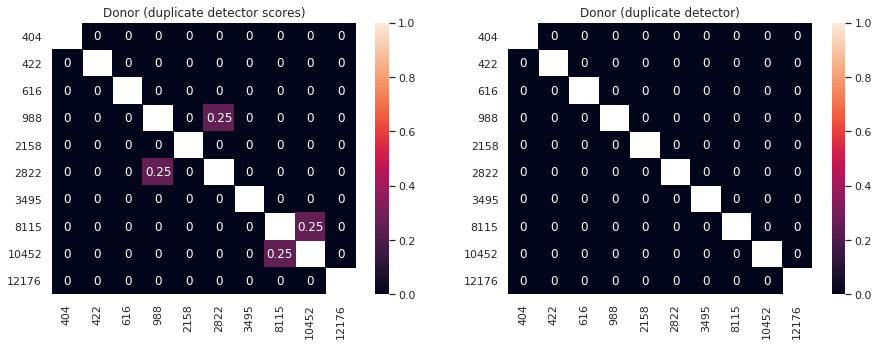

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

distance_matrix = distance_table.pivot('donor_id1', 'donor_id2', 'duplicate_score')

sns.heatmap(distance_matrix.values[:10, :10], 
            annot=True, 
            vmin=0, 
            vmax=1, 
            yticklabels=distance_matrix.columns.values[:10],
            xticklabels=distance_matrix.columns.values[:10],
            ax=ax1)

ax1.set_title('Donor (duplicate detector scores)')

distance_matrix = distance_table.pivot('donor_id1', 'donor_id2', 'duplicate').astype(float)

sns.heatmap(distance_matrix.values[:10, :10], 
            annot=True, 
            vmin=0, 
            vmax=1, 
            yticklabels=distance_matrix.columns.values[:10],
            xticklabels=distance_matrix.columns.values[:10],
            ax=ax2)

ax2.set_title('Donor (duplicate detector)');

How many duplicates did we detect?

In [129]:
distance_table.duplicate.sum()

8

As a fraction of the donor subset?

In [130]:
f"{distance_table.duplicate.sum() / donors.shape[0]:2.1%}"

'1.1%'